# ベクトル自己回帰モデル(Vector AutoRegression model)

VARモデルは予測を出すだけでなく、時系列データの相互作用を調べることもできる。

## VARモデルの使い時

個人消費と個人収入の時系列データがあったとする。  

- 個人消費が増えると個人収入は増える？
- 個人収入が増えると個人消費は増える？

このような状況をモデル化することができるのがVARモデル。便利。  

- 複数の時系列データを統合してモデル化することができる
- 変数間の影響を調べるのに役立つ

## VARモデルの構造

消費と収入の関係を表してみると次のようになる。**同時点の相手のデータ** がモデルに含まれていないことに注意する。

$$
    y_t = c_1 + \phi_{11}y_{t-1} + \phi_{12}x_{t-1} +  \varepsilon_{1t} \\
    x_t = c_2 + \phi_{21}y_{t-1} + \phi_{22}x_{t-1} +  \varepsilon_{2t} \\
$$

$$
    2001年の消費 = c_1 + \phi_{11}2000年の消費 + \phi_{12}2000年の収入 +  ノイズ \\
    2001年の収入 = c_2 + \phi_{21}2000年の消費 + \phi_{12}2000年の収入 +  ノイズ \\
$$

変数*n*個の*p*次の***VAR(p)*** は以下のように表される


$$
    \boldsymbol{y}_t = \boldsymbol{c} + \boldsymbol{\phi}_1\boldsymbol{y}_{t-1} + \cdots + \boldsymbol{\phi}_p\boldsymbol{y}_{t-p} + \boldsymbol{\varepsilon}_t
$$
- $\boldsymbol{y_t}$ : n x 1のベクトル
- $\boldsymbol{c}$ : n x 1のベクトル
- $\boldsymbol{\phi_i}$ : n x nのベクトル

## Granger因果性検定

- 「相手がいることによって、予測精度が上がるかどうか」を検定する。  
- 今、消費がいることによって、収入の予測が向上するかどうかを判断することができる。
- 「相手のデータを使うことで、予測残差が有意に減少したか」を検定する。
- Granger因果性検定は定常データを対処として分析した時にしか使うことができない。

## インパルス応用関数

- 消費が急に増えると収入はどういった影響があるのか、を定量的に評価する手法。
- ある変数にショックを与えてみて、その影響がどれほど続くのかをシミュレートする。

- 同時点のノイズは相関をもつことがあるので、これを相関をしている部分と独立な部分にわける(**直工かく乱項**)。

- 残差を直行化してからインパルス応答関数を求める方法を**直行化インパルス応答関数** と呼ぶ。


In [1]:
# パッケージのインストール
# install.packages("fpp")
# install.packages("vars")

In [2]:
# パッケージの読み込み
library(urca)
library(fpp)
library(vars)
library(ggplot2)
library(ggfortify)

library(repr)

# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: fma

Loading required package: expsmooth

Loading required package: lmtest

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: tseries

Loading required package: MASS


Attaching package: 'MASS'


The following objects are masked from 'package:fma':

    cement, housing, petrol


Loading required package: strucchange

Loading required package: sandwich

Registered S3 methods overwritten by 'ggfortify':
  method                 from    
  autoplot.Arima         forecast
  autoplot.acf           forecast
  autoplot.ar            forecast
  autoplot.bats          forecast
  autoplot.decomposed.ts forecast
  autoplot.ets           forecast
  autoplot.forecast      forecast
  autoplot.stl           forecast
  autop

In [3]:
# 分析の対象
# fppパッケージのusconsumptionという多変量データを使用する。
# 4半期ごとのアメリカの消費・収入の増加率データ
head(usconsumption)

,consumption,income
1970 Q1,0.6122769,0.496540
1970 Q2,0.4549298,1.736460
1970 Q3,0.8746730,1.344881
1970 Q4,-0.2725144,-0.328146
1971 Q1,1.8921870,1.965432
1971 Q2,0.9133782,1.490757


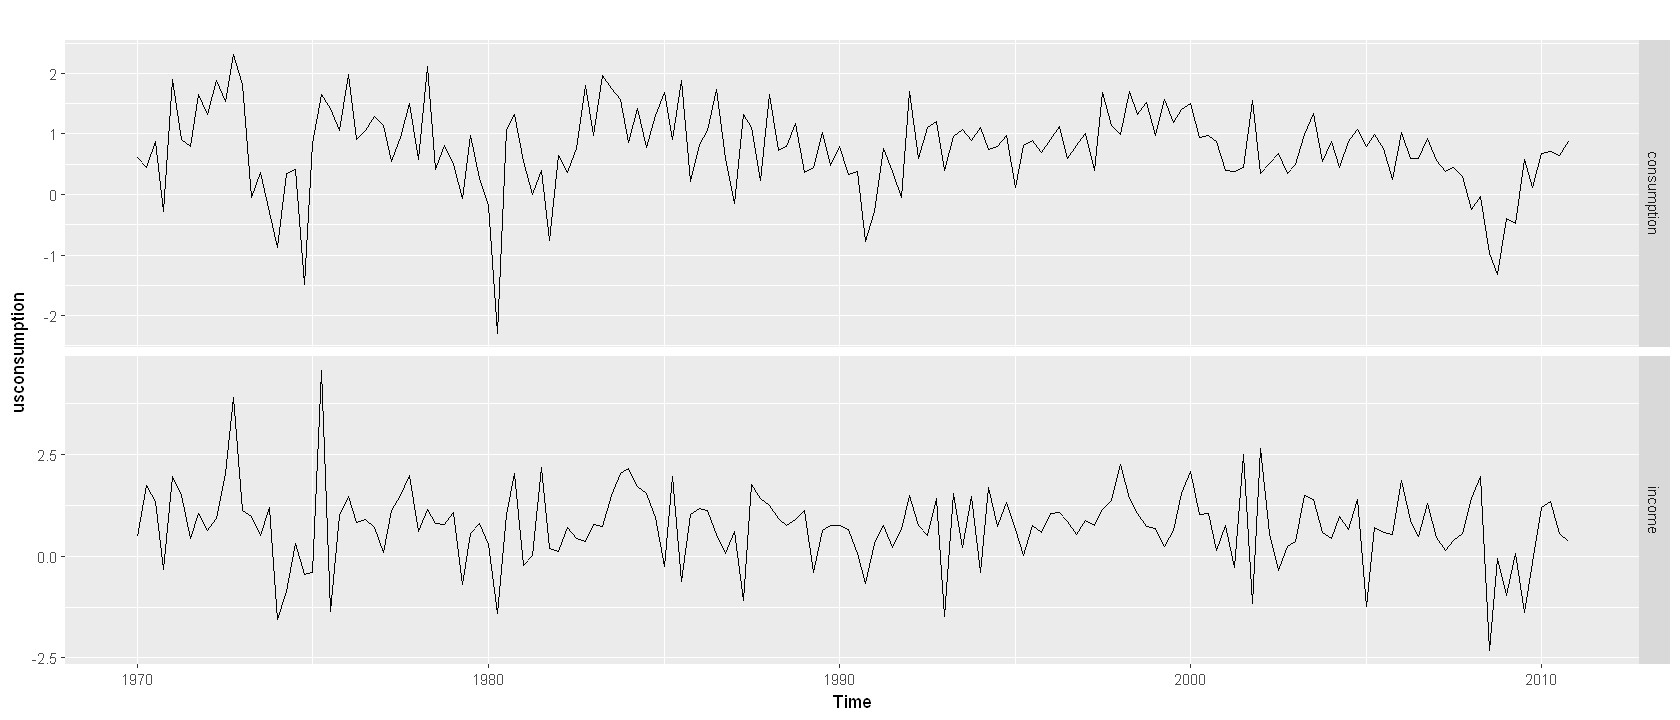

In [4]:
# 図示
autoplot(usconsumption, facets = T)

In [5]:
# ADF検定をして単位根が無い(定常性)を確かめる
# summary(ur.df(usconsumption[, "cunsumption"]), type="drift")

In [6]:
# summary(ur.df(usconsumption[, "income"]), type="drift")

Warning message:
"`mutate_()` is deprecated as of dplyr 0.7.0.
Please use `mutate()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


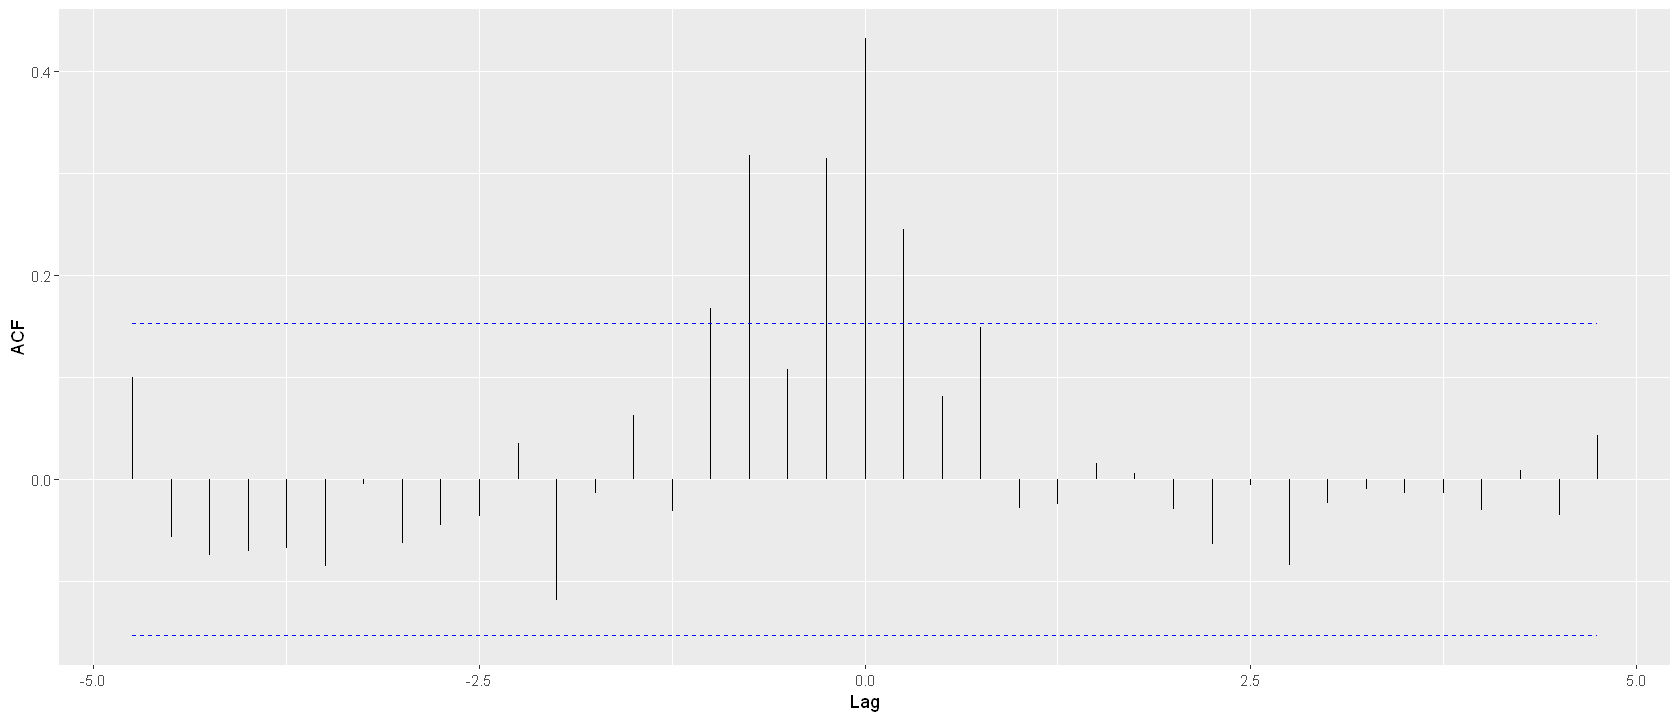

In [7]:
autoplot(
    ccf(
        usconsumption[, "consumption"],
        usconsumption[, "income"],
        plot = F
    )
)

## RによるVARモデル

VARモデルの次数もARIMAと同様にAICが最小となる次数を選択する。  
varsパッケージのVARSelect関数を使用して次数を選択していく。

In [9]:
select_result <- VARselect(usconsumption, lag.max=10, type="const")
select_result

,1,2,3,4,5,6,7,8,9,10
AIC(n),-1.2669809,-1.254039,-1.2991953,-1.3141205,-1.3295668,-1.2939806,-1.2634257,-1.2409677,-1.2158338,-1.1808584
HQ(n),-1.2189185,-1.173935,-1.1870496,-1.1699332,-1.1533379,-1.0857100,-1.0231135,-0.9686139,-0.9114384,-0.8444214
SC(n),-1.1486581,-1.056834,-1.0231087,-0.9591520,-0.8957165,-0.7812483,-0.6718115,-0.5704717,-0.4664559,-0.3525986
FPE(n),0.2816835,0.285363,0.2727854,0.2687822,0.2647208,0.2743982,0.2830345,0.2896272,0.2972129,0.3080666


AICを見ると、5次が最も小さくなっているのがわかる

In [10]:
select_result$selection[1]

AIC(n) 
     5

In [11]:
var_bestorder <- VAR(
    y = usconsumption,
    type = "const",
    p = select_result$selection[1]
)

In [14]:
summary(var_bestorder)


VAR Estimation Results:
Endogenous variables: consumption, income 
Deterministic variables: const 
Sample size: 159 
Log Likelihood: -321.616 
Roots of the characteristic polynomial:
0.7403 0.7403 0.7208 0.6745 0.6745  0.58  0.58 0.5484 0.5484 0.01889
Call:
VAR(y = usconsumption, p = select_result$selection[1], type = "const")


Estimation results for equation consumption: 
consumption = consumption.l1 + income.l1 + consumption.l2 + income.l2 + consumption.l3 + income.l3 + consumption.l4 + income.l4 + consumption.l5 + income.l5 + const 

                Estimate Std. Error t value Pr(>|t|)    
consumption.l1  0.248764   0.085965   2.894 0.004382 ** 
income.l1       0.059566   0.063446   0.939 0.349337    
consumption.l2  0.197200   0.089569   2.202 0.029238 *  
income.l2      -0.102497   0.065299  -1.570 0.118631    
consumption.l3  0.298879   0.090395   3.306 0.001186 ** 
income.l3      -0.054073   0.063907  -0.846 0.398851    
consumption.l4 -0.030031   0.094230  -0.319 0.750404    

## VARモデルによる予測

In [15]:
predict(var_bestorder, n.ahead=4)

$consumption
          fcst      lower    upper       CI
[1,] 0.7094253 -0.4974526 1.916303 1.206878
[2,] 0.7081061 -0.5467373 1.962950 1.254843
[3,] 0.7565104 -0.5411200 2.054141 1.297630
[4,] 0.7946358 -0.5737016 2.162973 1.368337

$income
          fcst      lower    upper       CI
[1,] 0.8326177 -0.7697598 2.434995 1.602378
[2,] 0.4631307 -1.2414527 2.167714 1.704583
[3,] 0.7626169 -0.9421448 2.467379 1.704762
[4,] 0.8631555 -0.9545267 2.680838 1.817682


Warning message:
"`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


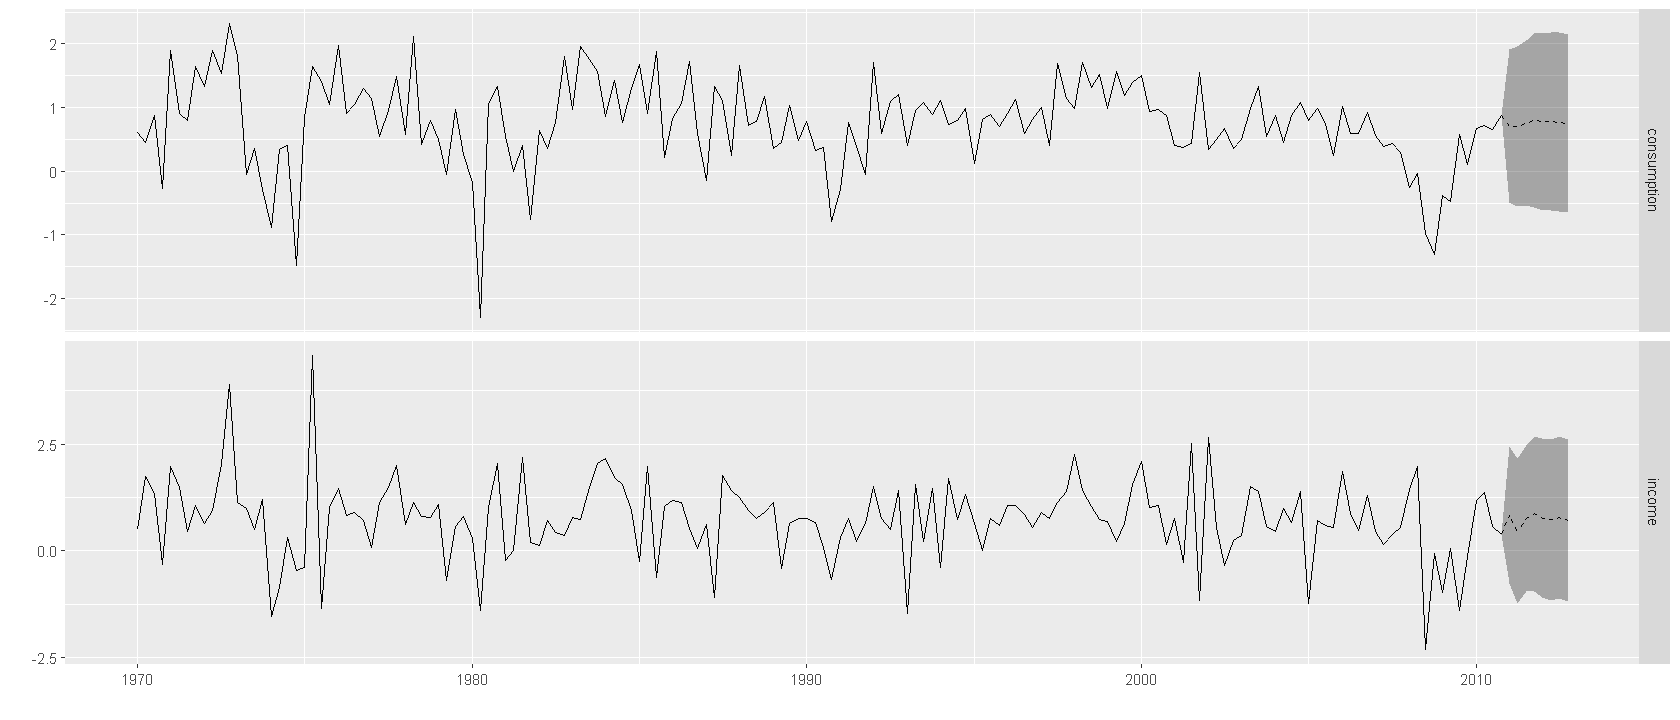

In [16]:
# 8時点先までの予測結果を図示する
autoplot(
    predict(var_bestorder, n.ahead=8),
    ts.colour = 1,
    predict.colour = 1,
    predict.linetype = 'dashed'
)

## RによるGranger因果性検定

varsパッケージのcausality関数を使用する。

In [17]:
# 収入が消費に与える影響
causality(var_bestorder, cause = "income")

$Granger

	Granger causality H0: income do not Granger-cause consumption

data:  VAR object var_bestorder
F-Test = 1.4337, df1 = 5, df2 = 296, p-value = 0.212


$Instant

	H0: No instantaneous causality between: income and consumption

data:  VAR object var_bestorder
Chi-squared = 15.492, df = 1, p-value = 8.285e-05



- GrangerがGrander因果性検定の結果を表している。p-value=0.212であり、p値が0.05よりも大きいので、Grangerの因果があるとは言えない。  
- InstantはGranderの瞬時因果性と呼ばれる因果の検定結果。

In [18]:
# 収入が消費に与える影響
causality(var_bestorder, cause = "consumption")

$Granger

	Granger causality H0: consumption do not Granger-cause income

data:  VAR object var_bestorder
F-Test = 10.575, df1 = 5, df2 = 296, p-value = 2.334e-09


$Instant

	H0: No instantaneous causality between: consumption and income

data:  VAR object var_bestorder
Chi-squared = 15.492, df = 1, p-value = 8.285e-05



Granderの因果性も瞬時因果性も、ともに有意となった。  

Granderの因果は「消費⇒収入」方向に存在した。その逆は有意なGrangerの因果は見られなかった。  
同時刻における消費と収入は、互いに影響を及ぼしあっていると示唆された。

## Rによるインパルス応答関数

Grangerの因果は「消費⇒収入」方向に存在した。  
消費が急に増えると、収入はどれくらいのラグが開いた後に増減するのか、インパルス関数を求めることによって調べられる。  
varsパッケージのirf関数を使用する。

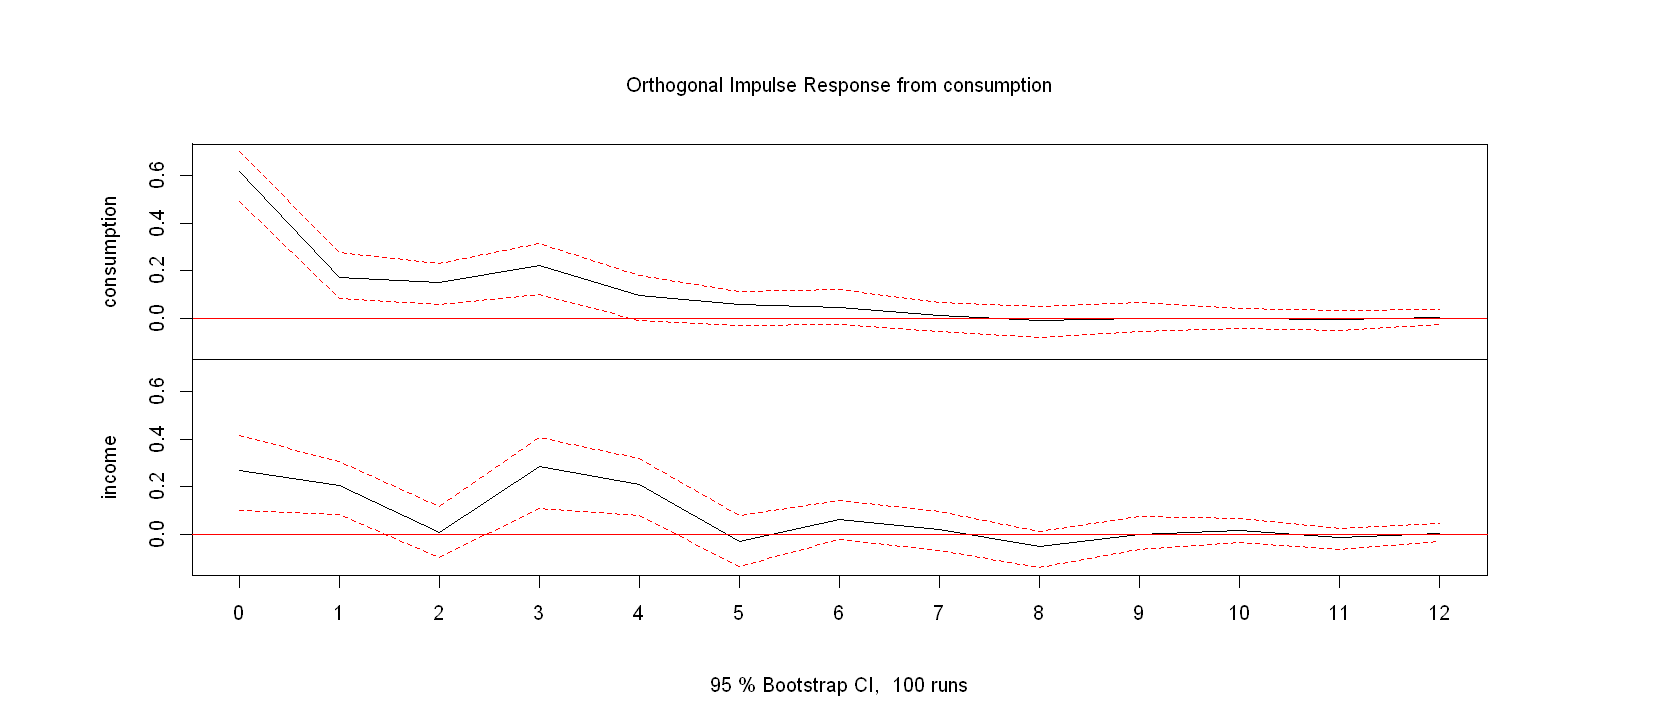

In [19]:
# インパルス応答関数
irf_consumption <- irf(
    var_bestorder, 
    impulse = "consumption",
    response = c("consumption", "income"),
    n.ahead = 12,
    boot = T
)

plot(irf_consumption)

- 3年後に消費が増えたとしても、収入は2年後くらいにはほぼその効果がなくなることがわかる。  

相手のデータの影響をどれほど受けているかを調べる**(分散分解)** 。

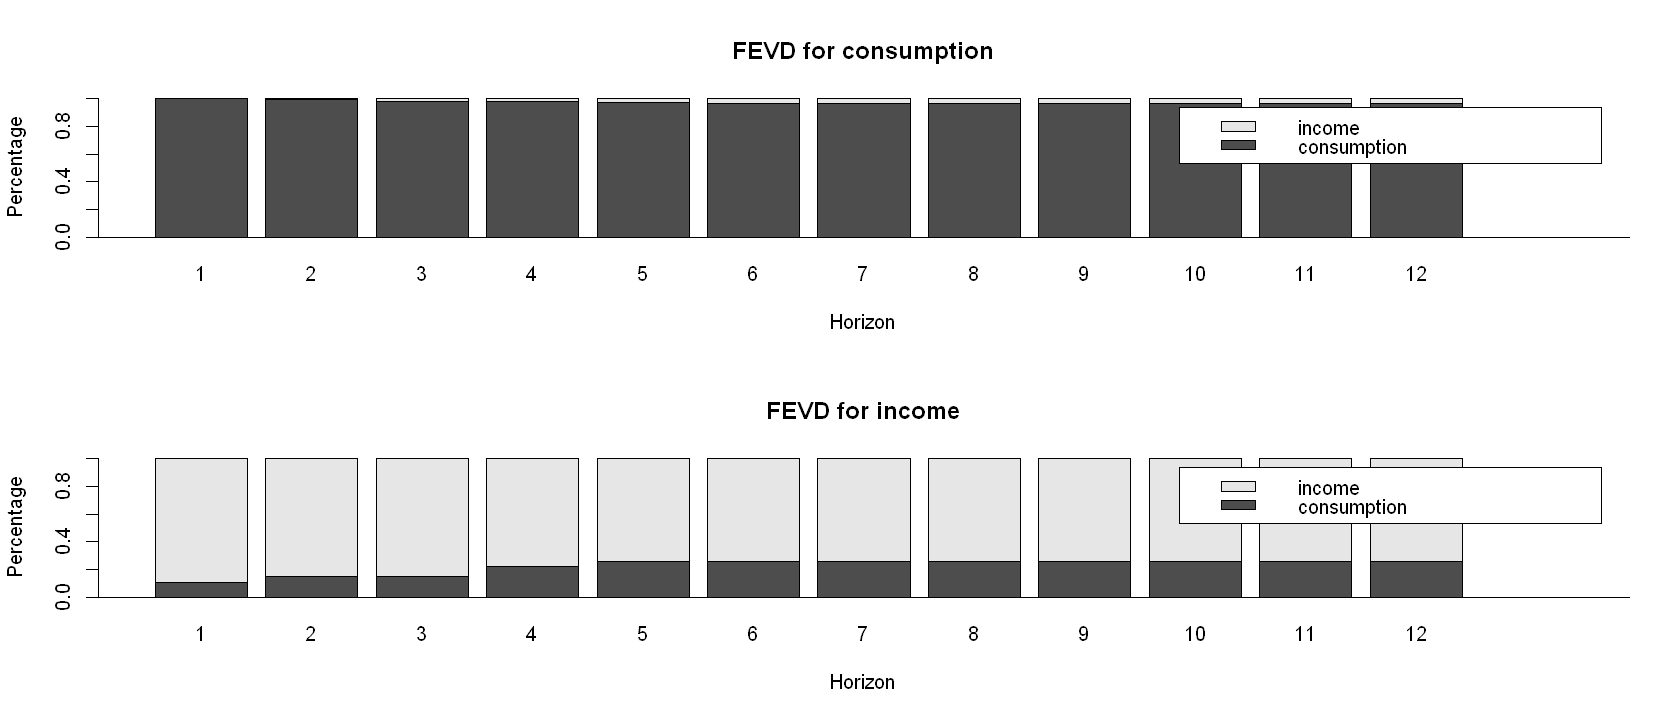

In [20]:
plot(fevd(var_bestorder, n.ahead=12))

消費に関してはほぼ収入の影響を受けていないが、収入に関しては1年後には25％も消費の影響を受けている。